# check properties of images

In [179]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

In [180]:
from PIL import Image, ImageOps
image_path = "/home/pasquale/Documents/card_e_ifo_originali/card/backup/ill/CARD1BS-17.tif"
image = Image.open(image_path)
print(f"Image mode: {image.mode}") #if I;16 don't forget to convert to rgb

Image mode: I;16


In [181]:


# Check the number of channels
num_channels = len(image.getbands())
print(f'Number of channels: {num_channels}')

Number of channels: 1


In [182]:
# Convert to numpy array
image_np = np.array(image)
# Normalize the pixel values to the range [0, 255]
image_np = (image_np / 65535.0) * 255.0
image_np = image_np.astype(np.uint8)

#mean = np.mean(image_np)
#std = np.std(image_np)
#normalized_image = (image_np - mean) / std

# Convert the normalized image to a PIL image
#image = Image.fromarray(image_np)

In [183]:
np.shape(image_np)

(2538, 1197)

In [184]:
# Stack the grayscale image into 3 identical channels to create an RGB image
image_rgb_np = np.stack((image_np,)*3, axis=-1)

# Convert the NumPy array to a PIL Image
image_rgb = Image.fromarray(image_rgb_np)

# Display the image (optional)
#image_rgb.show()

In [185]:


# Check the number of channels
num_channels = len(image_rgb.getbands())
print(f'Number of channels: {num_channels}')

Number of channels: 3


In [186]:
img_array = np.array(image)
img_array.shape
# Check the range of pixel values
min_val = img_array.min()
max_val = img_array.max()
mean_val = img_array.mean()
std_val = img_array.std()

print(f"Min pixel value: {min_val}, Max pixel value: {max_val}")
print(f"Mean pixel value: {mean_val}, std pixel value: {std_val}")

Min pixel value: 0, Max pixel value: 65535
Mean pixel value: 13516.710542444896, std pixel value: 16997.863993067953


# extract target value from excels

In [187]:
import pandas as pd
file_path = "/home/pasquale/Documents/card_e_ifo_originali/card/per_paziente_enh_noskin/"

name_files = ["roi_benigne_Card_CC_fixed.xlsx","roi_maligne_Card_CC_fixed.xlsx","roi_sane_1_CARD_fixed.xlsx"]


## import data

In [188]:
# Read the Excel file
df_benigne = pd.read_excel(file_path+name_files[0], skiprows=0, header=0)
# Display the first few rows of the DataFrame
df_benigne["malata"]=1
df_benigne.head()

,Global ID,slice,IS,x_centroide_1,y_centroide_1,width_1,height_1,malata
0,CARD100BS-18,18,1,910,1036,361,222,1
1,CARD100BS-19,19,1,910,1036,361,222,1
2,CARD100BS-20,20,1,910,1036,361,222,1
3,CARD100BS-21,21,1,910,1036,361,222,1
4,CARD100BS-22,22,1,910,1036,361,222,1


In [189]:
# Read the Excel file
df_maligne = pd.read_excel(file_path+name_files[1], skiprows=0, header=0)
df_maligne["malata"]=1
# Rename the column 'info' to 'slice'
df_maligne.rename(columns={'info': 'slice'}, inplace=True)
# Display the first few rows of the DataFrame
df_maligne.head()

,Global ID,slice,IS,x_centroide_1,y_centroide_1,width_1,height_1,malata
0,CARD100S-22,22,1,570,1067,497,426,1
1,CARD100S-23,23,1,570,1067,497,426,1
2,CARD100S-24,24,1,570,1067,497,426,1
3,CARD100S-25,25,1,570,1067,497,426,1
4,CARD100S-26,26,1,570,1067,497,426,1


In [190]:
# Check the column names ##
print(df_maligne.columns)

Index(['Global ID', 'slice', 'IS', 'x_centroide_1', 'y_centroide_1', 'width_1',
       'height_1', 'malata'],
      dtype='object')


In [191]:
# Read the Excel file
df_sane = pd.read_excel(file_path+name_files[2], skiprows=0, header=0)
df_sane["malata"]=0
# Display the first few rows of the DataFrame
df_sane.head()

,Global ID,slice,IS,x_centroide_1,y_centroide_1,width_1,height_1,malata
0,CARD10S-4,4,1,648,460,250,250,0
1,CARD10S-5,5,1,601,1182,250,250,0
2,CARD10S-6,6,1,444,753,250,250,0
3,CARD10S-7,7,1,766,441,250,250,0
4,CARD10S-8,8,1,604,1334,250,250,0


In [192]:
df = pd.concat([df_benigne,df_sane,df_maligne],ignore_index=True)

df.head()

,Global ID,slice,IS,x_centroide_1,y_centroide_1,width_1,height_1,malata
0,CARD100BS-18,18,1,910,1036,361,222,1
1,CARD100BS-19,19,1,910,1036,361,222,1
2,CARD100BS-20,20,1,910,1036,361,222,1
3,CARD100BS-21,21,1,910,1036,361,222,1
4,CARD100BS-22,22,1,910,1036,361,222,1



                    x_start_point = int(mass_centr_x - larghezza / 2)
                    y_start_point = int(mass_centr_y + altezza / 2)
                    x_end_point = int(mass_centr_x + larghezza / 2)
                    y_end_point = int(mass_centr_y - altezza / 2)

## delete rows

In [193]:
df = df[~df['Global ID'].isin(['CARD13BS-25','CARD13BS-26','CARD13BS-27','CARD13BS-28','CARD13BS-29','CARD13BS-30','CARD13BS-31','CARD13BS-32'])]

## crop image

In [194]:
def crop_image( image, center_x, center_y, width =600,height=600):
    crop_size=600
    """Crop the image centered at (center_x, center_y)"""
    left = max(center_x - width // 2, 0)
    top = max(center_y - height // 2, 0)
    right = min(center_x + width // 2, image.width)
    bottom = min(center_y + height // 2, image.height)

    # Crop the image
    cropped_image = image.crop((left, top, right, bottom))

    # Optional: If the crop is smaller than the required size, you can pad it
    # (this part is optional and depends on your use case)
    if cropped_image.size != (crop_size, crop_size):
        cropped_image = cropped_image.resize((crop_size, crop_size))

    return cropped_image

In [195]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class TumorDataset(Dataset):
    def __init__(self, root_dir,df=df, transform=None):
        """
        Args:
            root_dir (string): Directory with subfolders `sane` and `ill`.
            df: dataframe with centroids and area
            transform (callable, optional): Optional transforms to be applied
                on a sample (e.g., resizing, normalization).
        """
        self.root_dir = root_dir
        self.transform = transform
        self.df = df


    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):

        # Get the image filename and the label from the dataframe
        img_name = self.df.iloc[idx]['Global ID'] 
        label = self.df.iloc[idx]['malata'] 

        centroid_x, centroid_y = self.df.iloc[idx]['x_centroide_1'],self.df.iloc[idx]['y_centroide_1']
        width, height = self.df.iloc[idx]['width_1'],self.df.iloc[idx]['height_1']
        
        # Determine the folder path based on the label
        if label == 0:
            folder = 'Sane'
        else:
            folder = 'ill'

        # Construct the full path to the image
        img_path = os.path.join(self.root_dir, folder, img_name) +".tif"

        # Load the image
        image = Image.open(img_path)
        # Convert to numpy array
        image_np = np.array(image)
        # Normalize the pixel values to the range [0, 255]
        image_np = (image_np / 65535.0) * 255.0
        image_np = image_np.astype(np.uint8)
        # Stack the grayscale image into 3 identical channels to create an RGB image
        image_rgb_np = np.stack((image_np,)*3, axis=-1)
        # Convert the NumPy array to a PIL Image
        image = Image.fromarray(image_rgb_np)
        
        # Crop the image centered at (centroid_x, centroid_y)
        image = crop_image(image, centroid_x, centroid_y, width=600,height=600)
        
        if self.transform:
            image = self.transform(image)

        return image, label,img_name, centroid_x, centroid_y 

# instantiate dataset

In [196]:
root_dir = '/home/pasquale/Documents/card_e_ifo_originali/card/backup'

In [197]:
#mean=[0.485,0.456,0.406]
#std=[0.229, 0.224, 0.225]
mean= [15220.63,15220.63,15220.63]
std=  [16633.08,16633.08,16633.08]

In [198]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL image to PyTorch tensor
    #transforms.ConvertImageDtype(torch.float32), 
    transforms.Normalize(mean=mean, std=std),  # Normalize to range [0, 1]
    transforms.RandomRotation(degrees=45),  # Random rotation
    transforms.RandomHorizontalFlip(),  # Random horizontal flip
    transforms.RandomVerticalFlip()  # Random vertical flip
])

In [199]:
# Instantiate Dataset
dataset = TumorDataset(root_dir=root_dir,df=df, transform=transform)

In [200]:
# Create DataLoader
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=4)

# Example usage
for images, labels,img_name, centroid_x, centroid_y  in dataloader:
    print(images.shape)  # (batch_size, channels, 256, 256)
    print(labels)        # Tensor of size (batch_size,)
    print(img_name)
    print(centroid_x)
    print(centroid_y)

    break

torch.Size([16, 3, 600, 600])
tensor([0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1])
('CARD42S-13', 'CARD72S-34', 'CARD94BS-35', 'CARD46BS-19', 'CARD56S-20', 'CARD39S-30', 'CARD36BS-59', 'CARD33S-37', 'CARD14S-50', 'CARD47S-30', 'CARD23S-31', 'CARD34S-49', 'CARD7S-21', 'CARD7BS-55', 'CARD25S-53', 'CARD42S-52')
tensor([468, 195, 575, 500, 476, 276, 254, 278, 546, 556, 488, 457, 189, 399,
        200, 568])
tensor([1362,  655, 1547,  737, 1130, 1428,  426, 1534, 2418,  906, 1214, 1145,
         444, 1582,  782, 1244])


## verify the loader

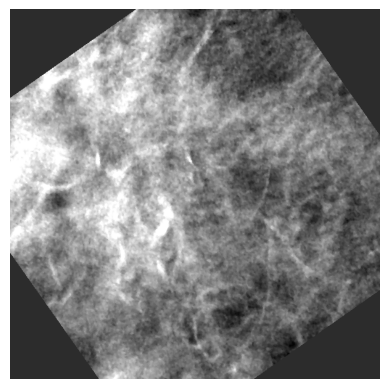

In [201]:
# Function to show an image
def imshow(image):
    # Convert the tensor to a NumPy array
    image = image.numpy().transpose((1, 2, 0))

    image = (image *std)+mean
    #image.transpose((1,2,0))


    # Unnormalize the image if it was normalized
    image = image * 255.0
    image = image.astype(np.uint8)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

# Show the first image in the batch
imshow(images[0])

In [202]:
def unnormalized_batch(images, mean=0, std=1):
    """Unnormalize a batch of images"""
    # Convert the images to NumPy arrays
    images_np = images.numpy()
    # Transpose the images to (batch_size, H, W, C)
    images_np = images_np.transpose((0, 2, 3, 1))
    # Unnormalize the images
    images_np = images_np * std + mean
    images_np = images_np * 255.0
    images_np = images_np.astype(np.uint8)
    return images_np

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.91508186..0.0].


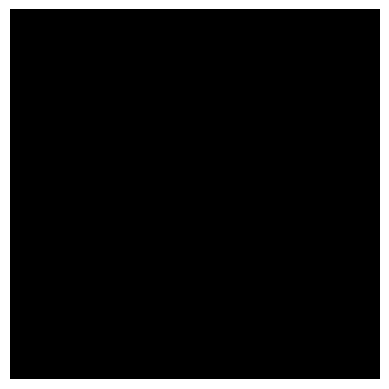

In [203]:




# Get a batch of images from DataLoader
images, labels,img_name, centroid_x, centroid_y  = next(iter(dataloader))
# Create a grid of images
grid = make_grid(images, nrow=4, padding=2)



# Convert the grid to a NumPy array
grid_np = grid.numpy().transpose((1, 2, 0))

# Display the grid
plt.imshow(grid_np)
plt.axis('off')
plt.show()
